

# **ECS7020P Mini-Project Submission Basic**





   Student Name: Aashika Elavarsan

   Student ID: 230356836







**Basic component [6 marks]**: Using the MLEnd Yummy Dataset, build a machine learning pipeline that takes as an input a photo of a dish that has either rice or chips and predicts whether the picture has rice or chips.



This machine learning pipeline is for predicting food images into 'Chips' and 'Rice'.

**Outline**

1. **Introduction**
   - Introduction to the methodology for predicting food images.

2. **Download Data**
   - Steps and sources for acquiring the food image dataset.

3. **Data Collection**
   - Overview of the dataset, including image sources and labeling process.

4. **Resizing Images**
   - Description of the method used for standardizing image dimensions.

5. **Creating Train and Test Datasets**
   - Approach for splitting the dataset into training and testing sets.

6. **Visualizing Dishes**
   - Techniques for displaying sample images for each category for validation.

7. **Preprocessing**
   - Detailed preprocessing steps applied to the images before feature extraction.

8. **Feature Extraction**
   - Process of extracting relevant features like color and texture from images.

9. **Normalization**
   - Techniques used to scale and normalize the features.

10. **Model Training**
    - Description of the machine learning model used and training process.

11. **Model Evaluation**
    - Methods and metrics used to assess the model's performance.

12. **Conclusion**
    - Final thoughts and summary of the outcomes and potential future work.



### **1. Introduction**

This documentation outlines the machine learning pipeline developed for the prediction of food images into two categories: 'Chips' and 'Rice'.

In [4]:
!pip install mlend

In [6]:
from google.colab import drive

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import spkit as sp

from skimage import exposure
from skimage.color import rgb2hsv, rgb2gray
import skimage as ski

import mlend
from mlend import download_yummy, yummy_load

import os, sys, re, pickle, glob
import urllib.request
import zipfile

import IPython.display as ipd
from tqdm import tqdm
import librosa

drive.mount('/content/drive')

Mounted at /content/drive


### **2. Download data**

Downloaded the MLEnd Yummy Dataset

In [8]:
import mlend
from mlend import download_yummy, yummy_load

subset = {}

datadir = download_yummy(save_to = '/content/drive/MyDrive/Data/MLEnd', subset = subset,verbose=1,overwrite=False)

100%|▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓|3250\3250|003250.jpg
Done!


In [9]:
os.listdir(datadir)

['MLEndYD_images_small',
 'MLEndYD_images',
 'MLEndYD_image_attributes_small.csv',
 'MLEndYD_image_attributes_benchmark.csv']

In [10]:
MLENDYD_df = pd.read_csv('/content/drive/MyDrive/Data/MLEnd/yummy/MLEndYD_image_attributes_benchmark.csv').set_index('filename')
MLENDYD_df

,Diet,Cuisine_org,Cuisine,Dish_name,Home_or_restaurant,Ingredients,Healthiness_rating,Healthiness_rating_int,Likeness,Likeness_int,Benchmark_A
filename,,,,,,,,,,,
000001.jpg,non_vegetarian,japanese,japanese,chicken_katsu_rice,marugame_udon,"rice,chicken_breast,spicy_curry_sauce",neutral,3.0,like,4.0,Train
000002.jpg,non_vegetarian,english,english,english_breakfast,home,"eggs,bacon,hash_brown,tomato,bread,tomato,bake...",unhealthy,2.0,like,4.0,Train
000003.jpg,non_vegetarian,chinese,chinese,spicy_chicken,jinli_flagship_branch,"chili,chicken,peanuts,sihuan_peppercorns,green...",neutral,3.0,strongly_like,5.0,Train
000004.jpg,vegetarian,indian,indian,gulab_jamun,home,"sugar,water,khoya,milk,salt,oil,cardamon,ghee",unhealthy,2.0,strongly_like,5.0,Train
000005.jpg,non_vegetarian,indian,indian,chicken_masala,home,"chicken,lemon,turmeric,garam_masala,coriander_...",healthy,4.0,strongly_like,5.0,Train
...,...,...,...,...,...,...,...,...,...,...,...
003246.jpg,vegetarian,indian,indian,zeera_rice,home,"1_cup_basmati_rice,2_cups_water,2_tablespoons_...",healthy,4.0,strongly_like,5.0,Train
003247.jpg,vegetarian,indian,indian,paneer_and_dal,home,"fried_cottage_cheese,ghee,lentils,milk,wheat_f...",healthy,4.0,strongly_like,5.0,Test
003248.jpg,vegetarian,indian,indian,samosa,home,"potato,onion,peanut,salt,turmeric_powder,red_c...",very_unhealthy,1.0,like,4.0,Test




### **3. Data Collection**

The dataset, `MLENDYD_df`, contains labeled images of dishes, each annotated with ingredients and dish names. A rigorous data processing routine was established to categorize each dish into 'Chips', 'Rice', or 'Both', based on the presence of key ingredients. The process involved:

- **Categorization**: A custom function `categorize_dish` identified the main components of each dish, excluding misleading terms like 'chocolate_chips'.
  
- **Refinement**: The dataset was filtered to exclude non-relevant variations such as 'rice_vinegar', ensuring that only desirable forms of rice were considered.

- **Cleaning**: A secondary filtering was applied to further refine the 'rice' category, followed by a cleanup step to remove any intermediate or unnecessary data attributes.



In [11]:
# categorization function
def categorize_dish(row):
    ingredients = row['Ingredients'].lower()
    dish_name = row['Dish_name'].lower()

    # Define unwanted keywords that could be misleading for 'chips'
    unwanted_keywords = ['chocolate_chips']

    # Check for the presence of unwanted keywords
    has_unwanted = any(keyword in ingredients for keyword in unwanted_keywords)

    # Adjust the check for 'chips' to exclude any unwanted cases
    has_rice = 'rice' in ingredients or 'rice' in dish_name
    has_chips = ('chips' in ingredients or 'fries' in ingredients or
                 'chips' in dish_name or 'fries' in dish_name) and not has_unwanted

    if has_rice and has_chips:
        return 'both'
    elif has_rice:
        return 'rice'
    elif has_chips:
        return 'chips'
    else:
        return 'none'

# Apply the first filter to categorize each dish
MLENDYD_df['rice_chips'] = MLENDYD_df.apply(categorize_dish, axis=1)

# Filter out the 'none' category
MLENDYD_df = MLENDYD_df[MLENDYD_df['rice_chips'] != 'none']

# combine 'both' category with 'rice'
MLENDYD_df['rice_chips'] = MLENDYD_df['rice_chips'].replace('both', 'rice')

# Define unwanted rice variations
unwanted_rice_variations = [
    'rice_vinegar', 'rice_noodles', 'rice_batter', 'rice_crisps', 'rice_urad_dal_batter',
    'rice_wine_vinegar', 'rice_cake', 'oil_rice', 'rice_flour_batter', 'fried_rice_masala',
    '_rice_flour_batter', 'rice_dough', 'for_roti:_rice_flour', 'rice_peanut_oil',
    'puttu_rice_flour', 'rice_vermicelli_noodle', 'paste_of_rice_and_black_gram',
    'flat_rice_noodles', 'sweet_rice_flour', 'rice_spaghetti', 'rice_flour',
    'cooked_rice_noodles', 'chinese_rice_vinegar'
]

# function to check for desired 'rice'
def contains_desired_rice(ingredients):
    for ingredient in ingredients.split(','):
        ingredient = ingredient.strip().lower()
        # Check if 'rice' is in the ingredient and it's not an unwanted variation
        if 'rice' in ingredient and not any(unwanted in ingredient for unwanted in unwanted_rice_variations):
            return True
    return False

# filter only to rows categorized as 'rice'
MLENDYD_df.loc[MLENDYD_df['rice_chips'] == 'rice', 'contains_desired_rice'] = MLENDYD_df[MLENDYD_df['rice_chips'] == 'rice']['Ingredients'].apply(contains_desired_rice)

# Filter out rows where 'contains_desired_rice' is False
MLENDYD_df = MLENDYD_df[~((MLENDYD_df['rice_chips'] == 'rice') & (MLENDYD_df['contains_desired_rice'] == False))]


MLENDYD_df.drop(columns=['contains_desired_rice'], inplace=True)

# The DataFrame MLENDYD_df is cleaned


<ipython-input-11-6e6c646c5d76>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-11-6e6c646c5d76>:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [12]:
MLENDYD_df

,Diet,Cuisine_org,Cuisine,Dish_name,Home_or_restaurant,Ingredients,Healthiness_rating,Healthiness_rating_int,Likeness,Likeness_int,Benchmark_A,rice_chips
filename,,,,,,,,,,,,
000001.jpg,non_vegetarian,japanese,japanese,chicken_katsu_rice,marugame_udon,"rice,chicken_breast,spicy_curry_sauce",neutral,3.0,like,4.0,Train,rice
000016.jpg,vegan,indian,indian,khichdi,home,"rice,spices,herbs",healthy,4.0,neutral,3.0,Test,rice
000020.jpg,vegetarian,indian,indian,lentil-based_vegetable_stew_with__rice,home,ingredients:\nfor_cooking_rice:\n1_cup_rice_(a...,healthy,4.0,like,4.0,Test,rice
000021.jpg,non_vegetarian,asian,asian,biryani,home,"mutton,rice,onion,tomato,red_chilli_powder,sal...",healthy,4.0,strongly_like,5.0,Train,rice
000022.jpg,vegetarian,indian,indian,rice_beetroot_curry,home,"rice,beetroot,salt,spices",very_healthy,5.0,neutral,3.0,Train,rice
...,...,...,...,...,...,...,...,...,...,...,...,...
003234.jpg,vegetarian,indian,indian,rasam_rice,home,"garlic,curry_leaves,green_chilli,cumin,black_p...",very_healthy,5.0,strongly_like,5.0,Test,rice
003236.jpg,non_vegetarian,german/turkish,german_turkish,german_doner_kebab,gdk,"lettuce,tomato,onion,red_cabbage,bread,yoghurt...",unhealthy,2.0,strongly_like,5.0,Train,chips
003243.jpg,vegetarian,british,british,pan-fried_beef_with_rice,restaurant,"rice,corn,beef,red_cabbage",healthy,4.0,dislike,2.0,Train,rice


In [13]:
# Count the occurrences of each category in 'rice_chips' column
counts = MLENDYD_df['rice_chips'].value_counts()

# Print the counts
print(counts)


rice     703
chips    139
Name: rice_chips, dtype: int64



Rice: 703 occurrences
Chips: 139 occurrences


The majority of dishes are categorized as 'rice' dishes, with a significantly smaller number categorized as 'chips' dishes

### **4. Resizing Images**

Images are not of same size. Our first step will be to resize all the images to so that they have the same size.

To keep the aspect ratio of image as it is, we will append black color to make so that images are squared and then we will resize them to 200x200 pixels.



In [66]:
sample_path = '/content/drive/MyDrive/Data/MLEnd/yummy/MLEndYD_images/*.jpg'
files = glob.glob(sample_path)
len(files)

3250

Let's have a look at the first two photos:





(-0.5, 1207.5, 907.5, -0.5)

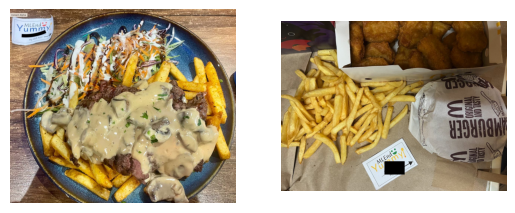

In [67]:
I = plt.imread('/content/drive/MyDrive/Data/MLEnd/yummy/MLEndYD_images_small/00001.jpg')
plt.subplot(1,2,1)
plt.imshow(I)
plt.axis('off')

I = plt.imread('/content/drive/MyDrive/Data/MLEnd/yummy/MLEndYD_images_small/00002.jpg')
plt.subplot(1,2,2)
plt.imshow(I)
plt.axis('off')

Both photos correspond to a dish that has chips. Note that their sizes are different.

### **5. Creating Train and Test Datasets**

The `yummy_large_load_from_df` function streamlines the dataset preparation for image classification, focusing on:

1. **Data Splitting**: Segregates data into training and testing sets based on predefined criteria.
2. **Path Generation**: Constructs file paths for image retrieval.
3. **Label Encoding**: Converts categorical labels into numerical form.
4. **Dataset Compilation**: Forms structured training and testing datasets with image paths and labels.

These steps ensure the data is model-ready, facilitating efficient training and testing processes.







In [68]:
import os

def yummy_large_load_from_df(df, image_dir, encode_labels=True):
    # Split DataFrame into training and testing based on 'Benchmark_A'
    train_df = df[df['Benchmark_A'] == 'Train']
    test_df = df[df['Benchmark_A'] == 'Test']


    X_train_paths = train_df.index.map(lambda x: os.path.join(image_dir, x)).tolist()
    X_test_paths = test_df.index.map(lambda x: os.path.join(image_dir, x)).tolist()

    # Define the label map for 'rice' and 'chips' only
    label_map = {'rice': 1, 'chips': 0}

    # Encode labels if required
    if encode_labels:
        Y_train_encoded = train_df['rice_chips'].map(label_map).values
        Y_test_encoded = test_df['rice_chips'].map(label_map).values
        maps = {'label_map': label_map}
    else:
        Y_train_encoded, Y_test_encoded, maps = None, None, {}

    TrainSet = {'X_paths': X_train_paths, 'Y': train_df['rice_chips'].values, 'Y_encoded': Y_train_encoded}
    TestSet = {'X_paths': X_test_paths, 'Y': test_df['rice_chips'].values, 'Y_encoded': Y_test_encoded}

    return TrainSet, TestSet, maps

# Image directory
image_dir = '/content/drive/MyDrive/Data/MLEnd/yummy/MLEndYD_images/'

# Create the datasets using the updated dataframe
TrainSet, TestSet, Map = yummy_large_load_from_df(MLENDYD_df, image_dir)


print("TrainSet keys:", TrainSet.keys())
print("TestSet keys:", TestSet.keys())
print("Number of training samples:", len(TrainSet['X_paths']))
print("Number of testing samples:", len(TestSet['X_paths']))


TrainSet keys: dict_keys(['X_paths', 'Y', 'Y_encoded'])
TestSet keys: dict_keys(['X_paths', 'Y', 'Y_encoded'])
Number of training samples: 573
Number of testing samples: 269


In [69]:

Map

{'label_map': {'rice': 1, 'chips': 0}}

In [70]:
TrainSet['Y']

array(['rice', 'rice', 'rice', 'chips', 'rice', 'rice', 'rice', 'rice',
       'rice', 'rice', 'rice', 'rice', 'chips', 'rice', 'rice', 'rice',
       'rice', 'rice', 'rice', 'rice', 'rice', 'rice', 'rice', 'chips',
       'rice', 'rice', 'rice', 'chips', 'rice', 'rice', 'rice', 'rice',
       'rice', 'rice', 'chips', 'chips', 'rice', 'rice', 'rice', 'rice',
       'rice', 'rice', 'chips', 'rice', 'rice', 'rice', 'rice', 'rice',
       'rice', 'rice', 'rice', 'chips', 'rice', 'chips', 'rice', 'rice',
       'rice', 'chips', 'chips', 'rice', 'rice', 'rice', 'chips', 'rice',
       'rice', 'rice', 'chips', 'rice', 'rice', 'rice', 'rice', 'rice',
       'rice', 'rice', 'chips', 'chips', 'rice', 'rice', 'rice', 'rice',
       'rice', 'rice', 'rice', 'rice', 'rice', 'rice', 'rice', 'rice',
       'rice', 'rice', 'rice', 'rice', 'rice', 'rice', 'rice', 'rice',
       'chips', 'rice', 'rice', 'rice', 'rice', 'rice', 'rice', 'rice',
       'chips', 'chips', 'rice', 'rice', 'rice', 'chips', 'ri

In [71]:
TrainSet['Y_encoded']

array([1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1,

In [72]:
X_train_paths = TrainSet['X_paths']
X_test_paths  = TestSet['X_paths']

Y_train = TrainSet['Y_encoded']
Y_test  = TestSet['Y_encoded']

### **6. Visualising dishes**



Rice


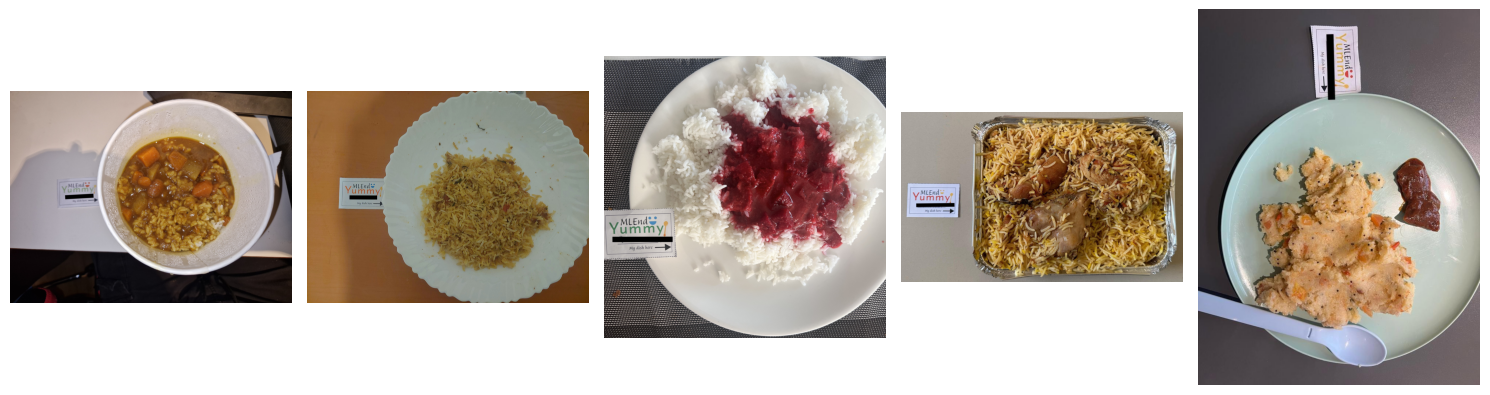

Chips


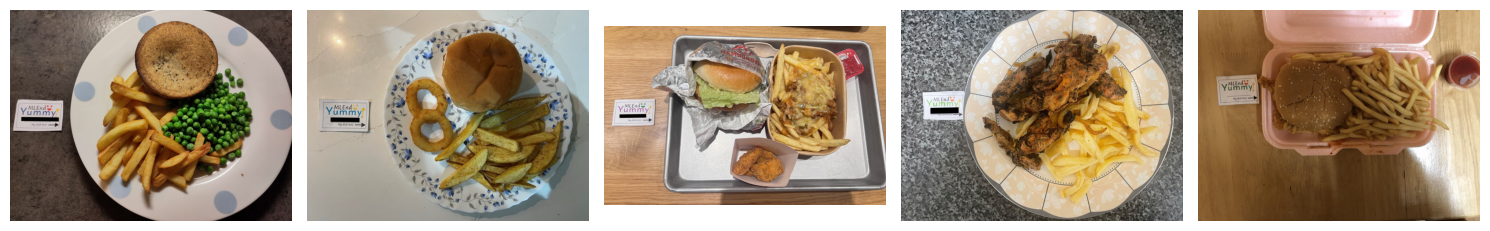

In [65]:
Chips_Img = np.array(X_train_paths)[Y_train==0]
Rice_Img = np.array(X_train_paths)[Y_train==1]

print('Rice')
plt.figure(figsize=(15,5))
for k,file in enumerate(Rice_Img[:5]):
  I = plt.imread(file)
  plt.subplot(1,5,k+1)
  plt.imshow(I)
  plt.axis('off')

plt.tight_layout()
plt.show()

print('Chips')
plt.figure(figsize=(15,5))
for k,file in enumerate(Chips_Img[:5]):
  I = plt.imread(file)
  plt.subplot(1,5,k+1)
  plt.imshow(I)
  plt.axis('off')

plt.tight_layout()
plt.show()


### **7. Preprocessing**

The preprocessing stage is essential for preparing the image data for optimal model performance.

1. **Image Categorization and Visualization**:
   - Sorting images into 'Chips' and 'Rice' based on labels and displaying samples for quality assurance.

2. **Preprocessing Functions**:
   - Utilizing make_it_square to adjust images to a uniform square shape.
   - Applying resize_img[link text](https://) to resize all images consistently to [200x200] pixels.

3. **Image Processing Workflow**:
   - Thoroughly processing all training and testing images, with progress monitoring.

4. **Data Preparation for Modeling**:
   - Converting processed images into NumPy arrays for compatibility with machine learning frameworks.
   - Validating array dimensions to match model input specifications.

5. **Quality Check with Visualization**:
   - Visual inspection of preprocessed images to ensure processing accuracy.



In [25]:
def make_it_square(I, pad=0):
  N,M,C = I.shape
  if N>M:
    Is = [np.pad(I[:,:,i], [(0,0),(0, N-M)], 'constant', constant_values=pad) for i in range(C)]
  else:
    Is = [np.pad(I[:,:,i], [(0, M-N),(0,0)], 'constant', constant_values=pad) for i in range(C)]

  return np.array(Is).transpose([1,2,0])

def resize_img(I,size=[100,100]):
  N,M,C = I.shape
  Ir = [sp.core.processing.resize(I[:,:,i],size) for i in range(C)]
  return np.array(Ir).transpose([1,2,0])

In [26]:
X_train = []
for k,file in enumerate(X_train_paths):
  sp.utils.ProgBar_JL(k,len(X_train_paths),L=50,color='blue')
  I = plt.imread(file)
  I = make_it_square(I, pad=0)
  I = resize_img(I,size=[200,200])
  X_train.append(I)


X_test = []
for k,file in enumerate(X_test_paths):
  sp.utils.ProgBar_JL(k,len(X_test_paths),L=50,color='blue')
  I = plt.imread(file)
  I = make_it_square(I, pad=0)
  I = resize_img(I,size=[200,200])
  X_test.append(I)

X_train = np.array(X_train)
X_test = np.array(X_test)
X_train.shape, X_test.shape

100%|▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓|573\573|
Done!
100%|▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓|269\269|
Done!


((573, 200, 200, 3), (269, 200, 200, 3))

Let's now plot a few images after resizing:

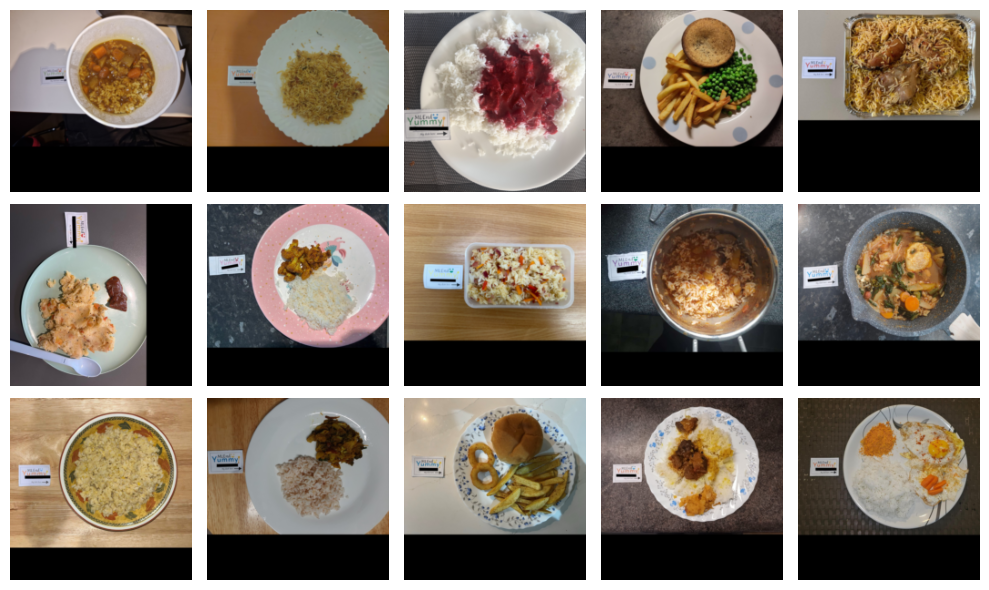

In [27]:
plt.figure(figsize=(10,6))
for k,I in enumerate(X_train):
  plt.subplot(3,5,k+1)
  plt.imshow(I)
  plt.axis('off')
  k+=1
  if k>=15:break
plt.tight_layout()
plt.show()

As you can see, all the images have a square shape and consist of 200x200 pixels.



### **8. Feature Extraction**
Each image is processed to extract meaningful features that serve as input for the machine learning model:
- **Color Features**: The yellow component is extracted from each image to quantify the presence of yellow, indicative of certain food types.
- **Texture Features**: Gray Level Co-occurrence Matrix (GLCM) features such as dissimilarity and correlation are computed to capture the textural characteristics of the images.*italicized text*

In [28]:
from skimage.feature import ORB
from skimage.feature import graycomatrix, graycoprops


def get_yellow_component(I,t1=27, t2=33):
  Ihsv = (rgb2hsv(I)*255).astype('uint8')
  mask = (Ihsv[:,:,0]<t2)*(Ihsv[:,:,0]>t1)
  Ypx = mask.sum()
  return Ypx

def GMLC_features(I):
  Ig = (rgb2gray(I)*255).astype('uint8')
  glcm = graycomatrix(Ig, distances=[5], angles=[0], levels=256,
                        symmetric=True, normed=True)
  f1 = graycoprops(glcm, 'dissimilarity')[0, 0]
  f2 = graycoprops(glcm, 'correlation')[0, 0]
  return f1,f2


def showConfMat(CM, labels = ['Chips','Rice']):
  plt.matshow(CM,cmap='Blues')
  for i in range(CM.shape[0]):
    for j in range(CM.shape[1]):
      plt.text(i,j,CM[i,j].round(2),ha='center',)
  plt.xticks([0,1],labels)
  plt.yticks([0,1],labels)
  plt.show()

In [29]:
X_train_f = []
for k, I in enumerate(X_train):
  f1 = get_yellow_component(I)
  f2,f3 = GMLC_features(I)
  X_train_f.append([f1,f2,f3])

X_test_f = []
for k, I in enumerate(X_test):
  f1 = get_yellow_component(I)
  f2,f3 = GMLC_features(I)
  X_test_f.append([f1,f2,f3])

In [30]:
X_train_f = np.array(X_train_f)
X_test_f = np.array(X_test_f)
X_train_f.shape, X_test_f.shape

((573, 3), (269, 3))

Note that `X_train_f` represents a collection of 573 samples described by 3 attributes and `X_test_f` represent a collection of 269 samples described by 3 attributes. This feature extraction stage has reduced the dimensionality of our problem from 120,000D to 3D.

### **9. Normalisation**


**Feature Scaling**:
`X_train_f` and `X_test_f` are scaled using the mean and standard deviation of the training features. This standardization ensures that all features contribute equally to the distance computations in the model.



In [31]:
MEAN = X_train_f.mean(0)
SD = X_train_f.std(0)

X_train_fn = (X_train_f - MEAN)/SD
X_test_fn = (X_test_f - MEAN)/SD

### **10. Model Training**


**Model Training with RandomForestClassifier**:
- Initialized a `RandomForestClassifier` with a specific number of trees (n_estimators=80) and maximum depth (max_depth=7), and class_weight='balanced' to handle class imbalance.
- The model is trained using the normalized training features X_train_fn and the training labels Y_train.

**Model Prediction and Evaluation**:
- The model makes predictions for both the training and test datasets.
- The training accuracy is approximately 87.08%, indicating a relatively high accuracy on the training data.
- The test accuracy is approximately 70.63%, which is lower than the training accuracy, suggesting that the model might be overfitting to the training data.



In [61]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest classifier
model = RandomForestClassifier(n_estimators=80, max_depth=7, min_samples_split=2, min_samples_leaf=1, class_weight='balanced')

# Train the model on the training data
model.fit(X_train_fn, Y_train)

# Predict the labels for the training data and test data
y_train_pred = model.predict(X_train_fn)
y_test_pred = model.predict(X_test_fn)

# Evaluate the accuracy
train_accuracy = np.mean(y_train_pred == Y_train)
test_accuracy = np.mean(y_test_pred == Y_test)

print('Random Forest Training Accuracy:', train_accuracy)
print('Random Forest Test Accuracy:', test_accuracy)

Random Forest Training Accuracy: 0.8708551483420593
Random Forest Test Accuracy: 0.7063197026022305


In [73]:
ytp = model.predict(X_train_fn)
ysp = model.predict(X_test_fn)

train_accuracy = np.mean(ytp==Y_train)
test_accuracy  = np.mean(ysp==Y_test)

print('Training Accuracy:\t',train_accuracy)
print('Test  Accuracy:\t',test_accuracy)

Training Accuracy:	 0.8708551483420593
Test  Accuracy:	 0.7063197026022305



### **11. Model Evaluation**

**Confusion Matrix Calculation and Visualization**:
- constructed a confusion matrix `CM`.
- The showConfMat function visualizes this confusion matrix, which indicates the proportion of true positives, true negatives, false positives, and false negatives.

The interpretations from the confusion matrix :

- **Top-left (True Negative / 'Chips' Accuracy)**: 27% of the 'Chips' class were correctly identified as 'Chips'.
- **Bottom-left (False Negative / 'Rice' Misclassification)**: 73% of the 'Chips' class were incorrectly identified as 'Rice'.
- **Top-right (False Positive / 'Chips' Misclassification)**: 21% of the 'Rice' class were incorrectly identified as 'Chips'.
- **Bottom-right (True Positive / 'Rice' Accuracy)**: 79% of the 'Rice' class were correctly identified as 'Rice'.



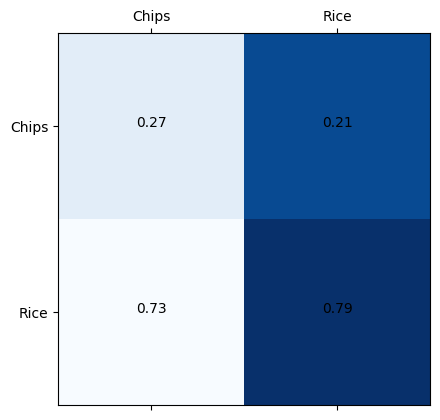

In [63]:
Ac = np.mean(ysp[Y_test.astype(int)==0]==0)
Ar = np.mean(ysp[Y_test.astype(int)==1]==1)

Mc = np.mean(ysp[Y_test.astype(int)==0]==1)
Mr = np.mean(ysp[Y_test.astype(int)==1]==0)

CM = np.array([[Ac, Mc],[Mr, Ar]])

showConfMat(CM)

In conclusion, this project serves as a valuable learning experience in handling class imbalances in dataset-driven machine learning tasks. It opens avenues for further research and development to refine the classification model, I am aiming for an equitable representation and recognition of both 'Chips' and 'Rice' categories.